# Librerías

In [10]:
import sys
import os
sys.path.append(".")
import re
import pandas as pd
import numpy as np
import pandasql as ps
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
def thousands_formatter_func(x, pos):
    return f'{int(x / 1e3)}K'
thousand_formatter = FuncFormatter(thousands_formatter_func)
def decimal_percentage_formatter_func(x, pos):
    return f'{int(x * 100)}%'
decimal_percentage_formatter = FuncFormatter(decimal_percentage_formatter_func)
def percentage_formatter_func(x, pos):
    return f'{int(x)}%'
percentage_formatter = FuncFormatter(percentage_formatter_func)

# Lectura archivos

In [11]:
df_bombs = pd.read_csv('data/processed_csv/df_bombs.csv', delimiter=',', encoding='latin-1', index_col=0)
df_of = pd.read_csv('data/processed_csv/df_of.csv', delimiter=',', encoding='latin-1')
df_operators = pd.read_csv('data/processed_csv/df_operators.csv', delimiter=',', encoding='latin-1')
df_operators_participation = pd.read_csv('data/processed_csv/df_operators_participation.csv', delimiter=',', encoding='latin-1')

df_bombs['start_date'] = pd.to_datetime(df_bombs['start_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['end_date'] = pd.to_datetime(df_bombs['end_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_of['start_date'] = pd.to_datetime(df_of['start_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_of['end_date'] = pd.to_datetime(df_of['end_date'], format='%Y-%m-%d %H:%M:%S.%f')



In [12]:
df_of.line = df_of.line.replace({"LÃ\x8dNEA 2": "LINEA_2", "LINEA_4": "LINEA_4", "LÃ\x8dNEA 1": "LINEA_1", "LINEA_6": "LINEA_6",
                    "LINEA 3": "LINEA_3", "LÃ\x8dNEA KIVU": "LINEA_KIVU", "PREFILTRO L-1": "PREFILTRO_L-1", "PREFILTRO L-6": "PREFILTRO_L-6",
                        "LINEA 7": "LINEA_7", "LINEA 8 IML": "LINEA_8_IML"})
df_operators_participation.line = df_operators_participation.line.replace({"LÃ\x8dNEA 2": "LINEA_2", "LINEA_4": "LINEA_4", "LÃ\x8dNEA 1": "LINEA_1", "LINEA_6": "LINEA_6",
                    "LINEA 3": "LINEA_3", "LÃ\x8dNEA KIVU": "LINEA_KIVU", "PREFILTRO L-1": "PREFILTRO_L-1", "PREFILTRO L-6": "PREFILTRO_L-6",
                        "LINEA 7": "LINEA_7", "LINEA 8 IML": "LINEA_8_IML"})

df_of.line.unique()

array(['LINEA_2', 'LINEA 4', 'LINEA 6', 'LINEA_1', 'LINEA_3',
       'LINEA_KIVU', 'PREFILTRO_L-1', 'PREFILTRO_L-6', 'LINEA_7',
       'LINEA_8_IML'], dtype=object)

In [13]:
def remove_special_chars(text):
    # Agrega los caracteres especiales que deseas eliminar, incluyendo los tildes
    special_chars = r"[^\w\sáéíóúÁÉÍÓÚñÑÃ]"
    text_without_special_chars = re.sub(special_chars, '', text)
    # Agrega aquí cualquier otro reemplazo adicional que desees realizar
    return text_without_special_chars

In [14]:
df_of['line'].apply(remove_special_chars)

0       LINEA_2
1       LINEA 4
2       LINEA 6
3       LINEA_1
4       LINEA 6
         ...   
5090    LINEA_2
5091    LINEA_2
5092    LINEA_2
5093    LINEA_7
5094    LINEA_7
Name: line, Length: 5095, dtype: object

In [15]:
df_of["weekday"] = df_of["start_date"].dt.weekday.astype("category")
df_of["turn"] = df_of["start_date"].apply(lambda x: 'AM' if x.hour < 14 else 'PM')
df_of["month"] = df_of["start_date"].dt.month.astype("category")
df_of["year"] = df_of["start_date"].dt.year.astype("category")


In [16]:
df_of.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"['9105', '918', '8177', '8164', '8230', '9104'...",10,11,44.226687,44.0,0.000000,0.0,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"['9120', '8866', '5020', '8860', '8822']",4,5,0.353680,0.0,0.000000,NaN,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"['9436', '9142', '5033']",8,3,34.185148,34.0,0.000000,0.0,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,['5025'],8,1,2.458296,2.0,0.813572,1.0,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"['504', '1007', '287', '8945']",2,4,11.835761,12.0,1.013877,1.0,0.961656,100% - 110%,5,AM,1,2020


# Distribución Performance

In [17]:
df_of.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"['9105', '918', '8177', '8164', '8230', '9104'...",10,11,44.226687,44.0,0.000000,0.0,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"['9120', '8866', '5020', '8860', '8822']",4,5,0.353680,0.0,0.000000,NaN,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"['9436', '9142', '5033']",8,3,34.185148,34.0,0.000000,0.0,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,['5025'],8,1,2.458296,2.0,0.813572,1.0,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"['504', '1007', '287', '8945']",2,4,11.835761,12.0,1.013877,1.0,0.961656,100% - 110%,5,AM,1,2020


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


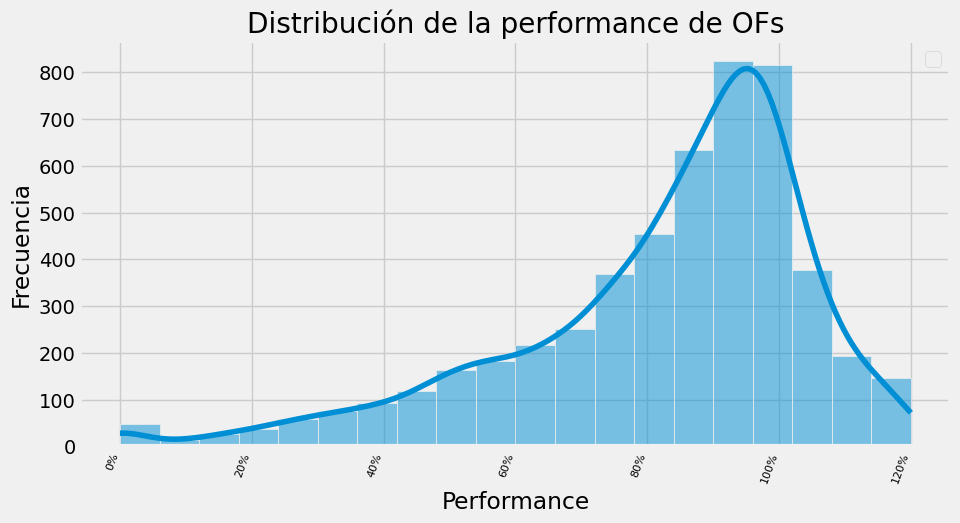

In [18]:
data = df_of.sort_values(by='performance', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(decimal_percentage_formatter_func)
plt.show()

# Distribución de Participación

In [19]:
df_operators_participation.head()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,bomb_type,line,theorical_qty,participation_category,performance_category
0,5025,5160396,185.933283,185.933283,100.0,0.914306,1210,LINEA_1,2.187450,95% - 100%,90% - 100%
1,5025,5165729,251.107000,251.107000,100.0,0.681622,01224-0890,LINEA_1,2.934179,95% - 100%,60% - 70%
2,5025,5169247,391.531283,779.781233,50.2,0.923336,1197,LINEA_1,9.747265,50% - 55%,90% - 100%
3,5004,5169247,388.249950,779.781233,49.8,0.923336,1197,LINEA_1,9.747265,45% - 50%,90% - 100%
4,5004,5171973,17.021267,367.533717,4.6,0.870668,01205-0810,LINEA_1,4.594171,0% - 5%,80% - 90%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


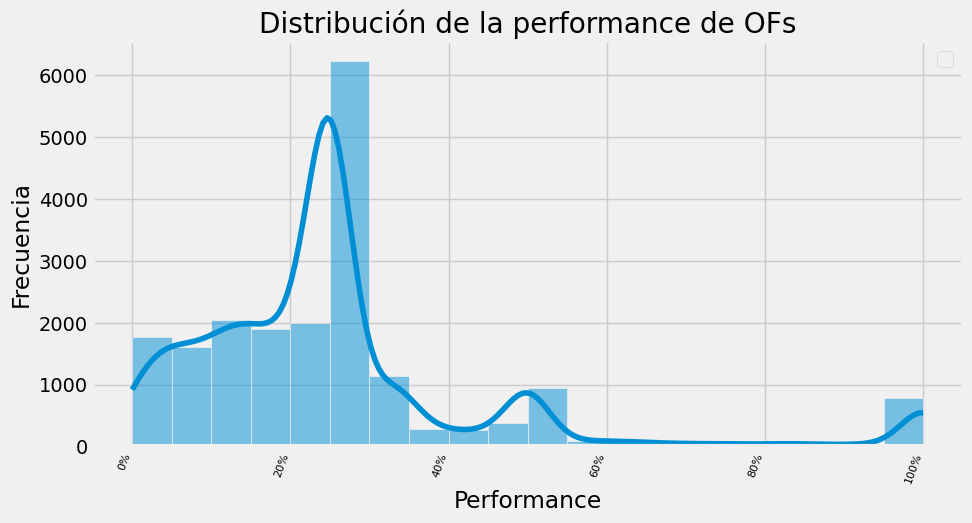

In [20]:
data = df_operators_participation.sort_values(by='participation_percentage', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='participation_percentage', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.gca().legend().set_visible(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


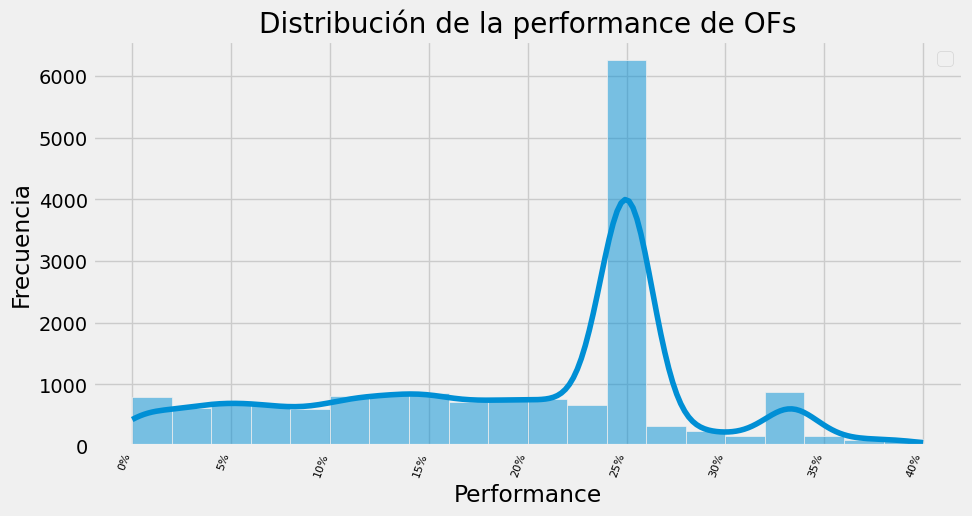

In [21]:
data = df_operators_participation[
    df_operators_participation.participation_percentage <= 40
].sort_values(by='participation_percentage', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='participation_percentage', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.gca().legend().set_visible(True)
plt.show()

In [22]:
df_operators_participation.describe()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,theorical_qty
count,19736.000000,1.973600e+04,19736.000000,19736.000000,19736.000000,19736.000000,19736.000000
mean,7426.565059,5.278015e+06,263.054343,1295.672538,25.814897,0.819490,167.045972
std,2996.455197,1.332644e+05,260.145323,1176.745070,20.383601,0.219201,186.184760
min,1.000000,2.741850e+05,0.037783,0.845000,0.000000,0.000000,0.119014
25%,8164.000000,5.228260e+06,74.698383,428.290967,13.800000,0.722176,38.380738
50%,8860.000000,5.295270e+06,195.278617,1072.099025,25.000000,0.885235,125.773474
75%,9265.000000,5.327082e+06,381.847204,1854.723296,25.400000,0.968393,254.020502
max,9994.000000,5.382060e+06,2808.686350,17392.383600,100.000000,1.199976,4181.596591


# Preparación Modelo

## Supuestos

Supuestos
* Se asume un corte de performance aceptable para una OF sobre el  80%
* Se asume una participación mínima deun 5% del tiempo de un operador en una OF para considerar que trabajó en ella
* Para entrenar, se asume que la cantidad de bombas realizadas (good_qty) era lo planificado a hacer para la OF
* Se quita del análisis líneas que no son de interés para el cliente (LINEA 8 IML)

In [23]:
df_of_model = df_of.copy()
df_operators_participation_model = df_operators_participation.copy()
df_operators_model = df_operators.copy()

perfomance_cutoff = 1
participation_cutoff = 0.05
exclude_lines= ['LINEA_8_IML']

In [24]:
df_of_model.drop(['operators_distinct_ids', 'plan_qty', 'theorical_qty_round', 'performance_round', 'total_good_qty', 'total_bad_qty'], axis=1, inplace=True)
df_of_model = df_of_model[df_of_model.line.isin(exclude_lines) == False]
df_operators_participation_model = df_operators_participation_model[df_operators_participation_model.line.isin(exclude_lines) == False]  
print(df_of_model.describe())
df_of_model.head()

              order     good_qty  bad_qty  theorical_diff  theorical_time  \
count  4.146000e+03  4146.000000   4146.0     4146.000000     4146.000000   
mean   5.261866e+06   116.314279      0.0    29155.041727       22.918215   
std    9.931992e+04   149.169024      0.0    24643.329769       27.358786   
min    2.741850e+05     0.000000      0.0       26.000000        0.500000   
25%    5.207982e+06    12.000000      0.0    12127.000000        6.870000   
50%    5.256418e+06    60.000000      0.0    23888.500000        8.210000   
75%    5.315732e+06   180.000000      0.0    38405.000000       21.540000   
max    5.382060e+06  3000.000000      0.0   376798.000000       96.000000   

       time_diff_seconds_calculated  time_diff_minutes_calculated  \
count                   4146.000000                   4146.000000   
mean                   29155.048052                    485.917468   
std                    24643.315610                    410.721927   
min                       25.3

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,10,11,44.226687,0.000000,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,4,5,0.353680,0.000000,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,8,3,34.185148,0.000000,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020


Removemos las OFs que no tenían cantidad palnificada *good_qty == 0*

In [25]:
df_of_model = df_of_model[df_of_model.good_qty != 0]

## Etiquetado de OFs

In [26]:
df_of_model['achieve_performance'] = df_of_model['performance'].apply(lambda x: 1 if x >= perfomance_cutoff else 0)
df_of_model.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
3,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0
4,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1
5,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0
6,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0
7,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0


## Etiquetado participacion

In [27]:
df_operators_participation_model['participation_indicator'] = df_operators_participation_model['participation_percentage'].apply(lambda x: 1 if x >= participation_cutoff*100 else 0)
df_operators_participation_model.head()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,bomb_type,line,theorical_qty,participation_category,performance_category,participation_indicator
0,5025,5160396,185.933283,185.933283,100.0,0.914306,1210,LINEA_1,2.187450,95% - 100%,90% - 100%,1
1,5025,5165729,251.107000,251.107000,100.0,0.681622,01224-0890,LINEA_1,2.934179,95% - 100%,60% - 70%,1
2,5025,5169247,391.531283,779.781233,50.2,0.923336,1197,LINEA_1,9.747265,50% - 55%,90% - 100%,1
3,5004,5169247,388.249950,779.781233,49.8,0.923336,1197,LINEA_1,9.747265,45% - 50%,90% - 100%,1
4,5004,5171973,17.021267,367.533717,4.6,0.870668,01205-0810,LINEA_1,4.594171,0% - 5%,80% - 90%,0


In [28]:
# Pivotear el dataframe df_operators_participation para obtener las columnas de operadores
df_operators_participation_model.drop_duplicates(inplace=True)
df_pivot = df_operators_participation_model.pivot(index='order', columns='operator_id', values='participation_indicator')
df_pivot = df_pivot.fillna(0)
df_pivot.columns = ['operator_' + str(col) for col in df_pivot.columns]
df_pivot = df_pivot.astype(int)
print(df_pivot.shape)
df_pivot.head()

(4146, 102)


,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
274185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5029646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5070828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5157110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5158184,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_merged = pd.merge(df_of_model, df_pivot, on='order', how='left')
df_merged.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# REVISAR CASO DE OPERADOR-ORDER duplicado
#df_operators_participation_model[(df_operators_participation_model.order == 5309158) & (df_operators_participation_model.operator_id == 1)]

# Pruebas modelos

## XGBoost Classifier

In [31]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
df = df_merged.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'bad_qty', 'theorical_diff', 'total_operators_minutes', 'theorical_qty',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated',
                   'time_diff_hours_calculated', 'performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [33]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [34]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [35]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [36]:
# Crear el clasificador XGBoost
model = xgb.XGBClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

result = X_test.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

Precisión del modelo: 81.97%


In [37]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,prediction_prob,order,bomb_type,line,bad_qty,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
2470,180.0,10.00,18,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.027287,5280827,73680,LINEA_3,0.0,2021-12-01 10:15:13.750,2021-12-02 12:18:57.700,36950,36949.407,615.823450,1845.141683,184.514168,0.975535,10.263724,90% - 100%,2,AM,12,2021,0
564,12.0,9.83,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.025493,5189979,20028,PREFILTRO_L-1,0.0,2020-05-15 07:49:18.700,2020-05-15 09:50:09.080,7251,7250.380,120.839667,188.458667,19.171787,0.625920,2.013994,60% - 70%,4,AM,5,2020,0
731,240.0,6.87,18,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.247028,5197715,65560,LINEA_2,0.0,2020-06-03 13:21:10.360,2020-06-04 13:10:29.777,32322,32322.197,538.703283,1650.169417,240.199333,0.999170,8.978388,90% - 100%,2,AM,6,2020,0
1073,90.0,21.54,37,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.121794,5209333,8005,LINEA 6,0.0,2020-08-05 10:16:43.327,2020-08-31 12:12:31.320,94411,94411.136,1573.518933,1949.779100,90.518993,0.994266,26.225316,90% - 100%,2,AM,8

In [38]:
df_of[df_of.order == 5294563]   

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
2693,5294563,25463-0810,LINEA 4,50.0,45.0,0.0,24.0,0.0,2022-01-13 06:49:13.607,2022-01-13 10:43:19.590,9327,7.1,9327.01,155.450167,310.900333,"['9279', '9120']",7,2,43.788779,44.0,0.548086,0.545455,2.590836,50% - 60%,3,AM,1,2022


In [39]:
# df_result_complete[df_result_complete.achieve_performance != df_result_complete.prediction]
df_result_complete[(df_result_complete.achieve_performance == 1) & (df_result_complete.prediction == 0)]

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,prediction_prob,order,bomb_type,line,bad_qty,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
1907,349.0,7.10,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.365540,5246083,74474-1194,LINEA 4,0.0,2021-05-06 10:57:58.667,2021-05-07 13:02:47.883,36966,36966.276,616.104600,2464.418400,347.101183,1.005470,10.268410,100% - 110%,3,AM,5,2021,1
109,12.0,80.00,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.020864,5170886,1195,LINEA_1,0.0,2020-01-30 10:26:38.210,2020-02-03 08:56:23.137,50196,50194.921,836.582017,870.134450,10.876681,1.103278,13.943034,0% - 10%,3,AM,1,2020,1
903,270.0,6.87,17,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.466823,5202954,65562,LINEA_2,0.0,2020-07-01 19:24:36.547,2020-07-02 11:56:47.730,32456,32455.887,540.931450,1825.512833,265.722392,1.016098,9.015524,100% - 110%,2,PM,7,2020,1
2227,240.0,6.87,24,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.017994,5265142,65562,LINEA_2,0.0,2021-07-26 12:04:48.127,2021-07-26 18:57:00.380,24732,24732.253,412.204217,1638.936917,238.564326,1.006018,6.870070,100% - 110%,0,AM

In [40]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

Puntuaciones de rendimiento en cada división: [0.79658952 0.80024361 0.80511571 0.77831912 0.75152253]
Media de las puntuaciones de rendimiento: 0.7863580998781974
Desviación estándar de las puntuaciones de rendimiento: 0.019634047921666148


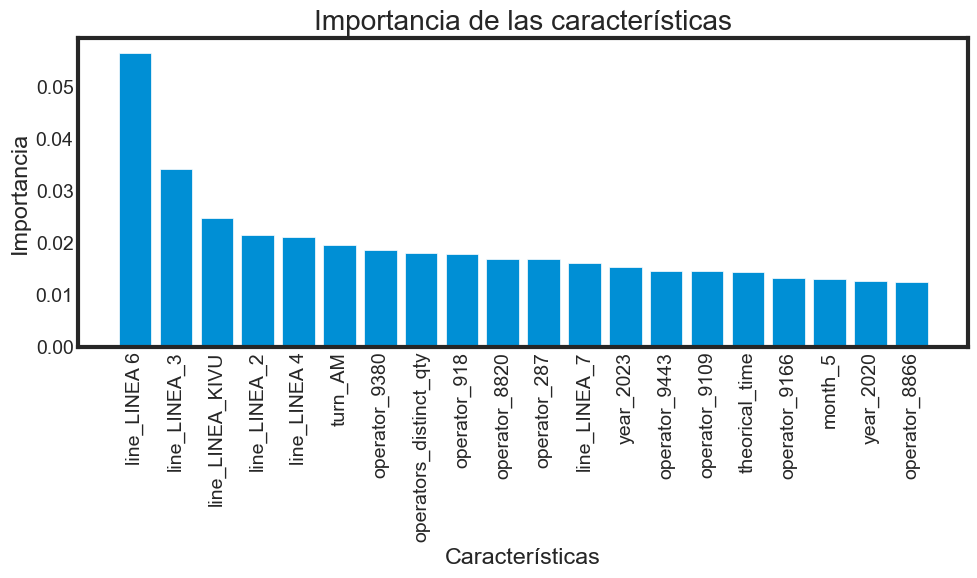

In [42]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:20]
sorted_feature_names = feature_names[indices][:20]

# Visualizar la importancia de las características en un gráfico de barras
sns.set_style('white')
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
import numpy as np

# Seleccionar las columnas relevantes para el análisis
columns = ['line_LINEA_3', 'line_LINEA_1', 'line_LINEA_2', 'good_qty', 'theorical_time', 'operator_9266', 'operator_1007', 'operator_504', 'performance']

# Crear un nuevo DataFrame con las columnas seleccionadas
df_corr = df_result_complete[columns]

# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)

                line_LINEA_3  line_LINEA_1  line_LINEA_2  good_qty  \
line_LINEA_3        1.000000     -0.144483     -0.306143  0.007777   
line_LINEA_1       -0.144483      1.000000     -0.235113 -0.272519   
line_LINEA_2       -0.306143     -0.235113      1.000000  0.356882   
good_qty            0.007777     -0.272519      0.356882  1.000000   
theorical_time     -0.199669      0.769413     -0.395143 -0.431944   
operator_9266      -0.050546     -0.038818      0.165106  0.164291   
operator_1007       0.133173     -0.013054     -0.195163 -0.135510   
operator_504        0.715247     -0.130334     -0.230446 -0.002037   
performance        -0.190938      0.066514      0.088763  0.227621   

                theorical_time  operator_9266  operator_1007  operator_504  \
line_LINEA_3         -0.199669      -0.050546       0.133173      0.715247   
line_LINEA_1          0.769413      -0.038818      -0.013054     -0.130334   
line_LINEA_2         -0.395143       0.165106      -0.195163     

Importance Permutatios

In [44]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las permutaciones
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Obtener los puntajes de importancia
importance_scores = result.importances_mean

In [45]:
df_importance_perm = pd.DataFrame({'feature': X_encoded.columns, 'importance': result.importances_mean})

In [46]:
data = df_importance_perm[df_importance_perm.importance != 0.00]
data = df_importance_perm

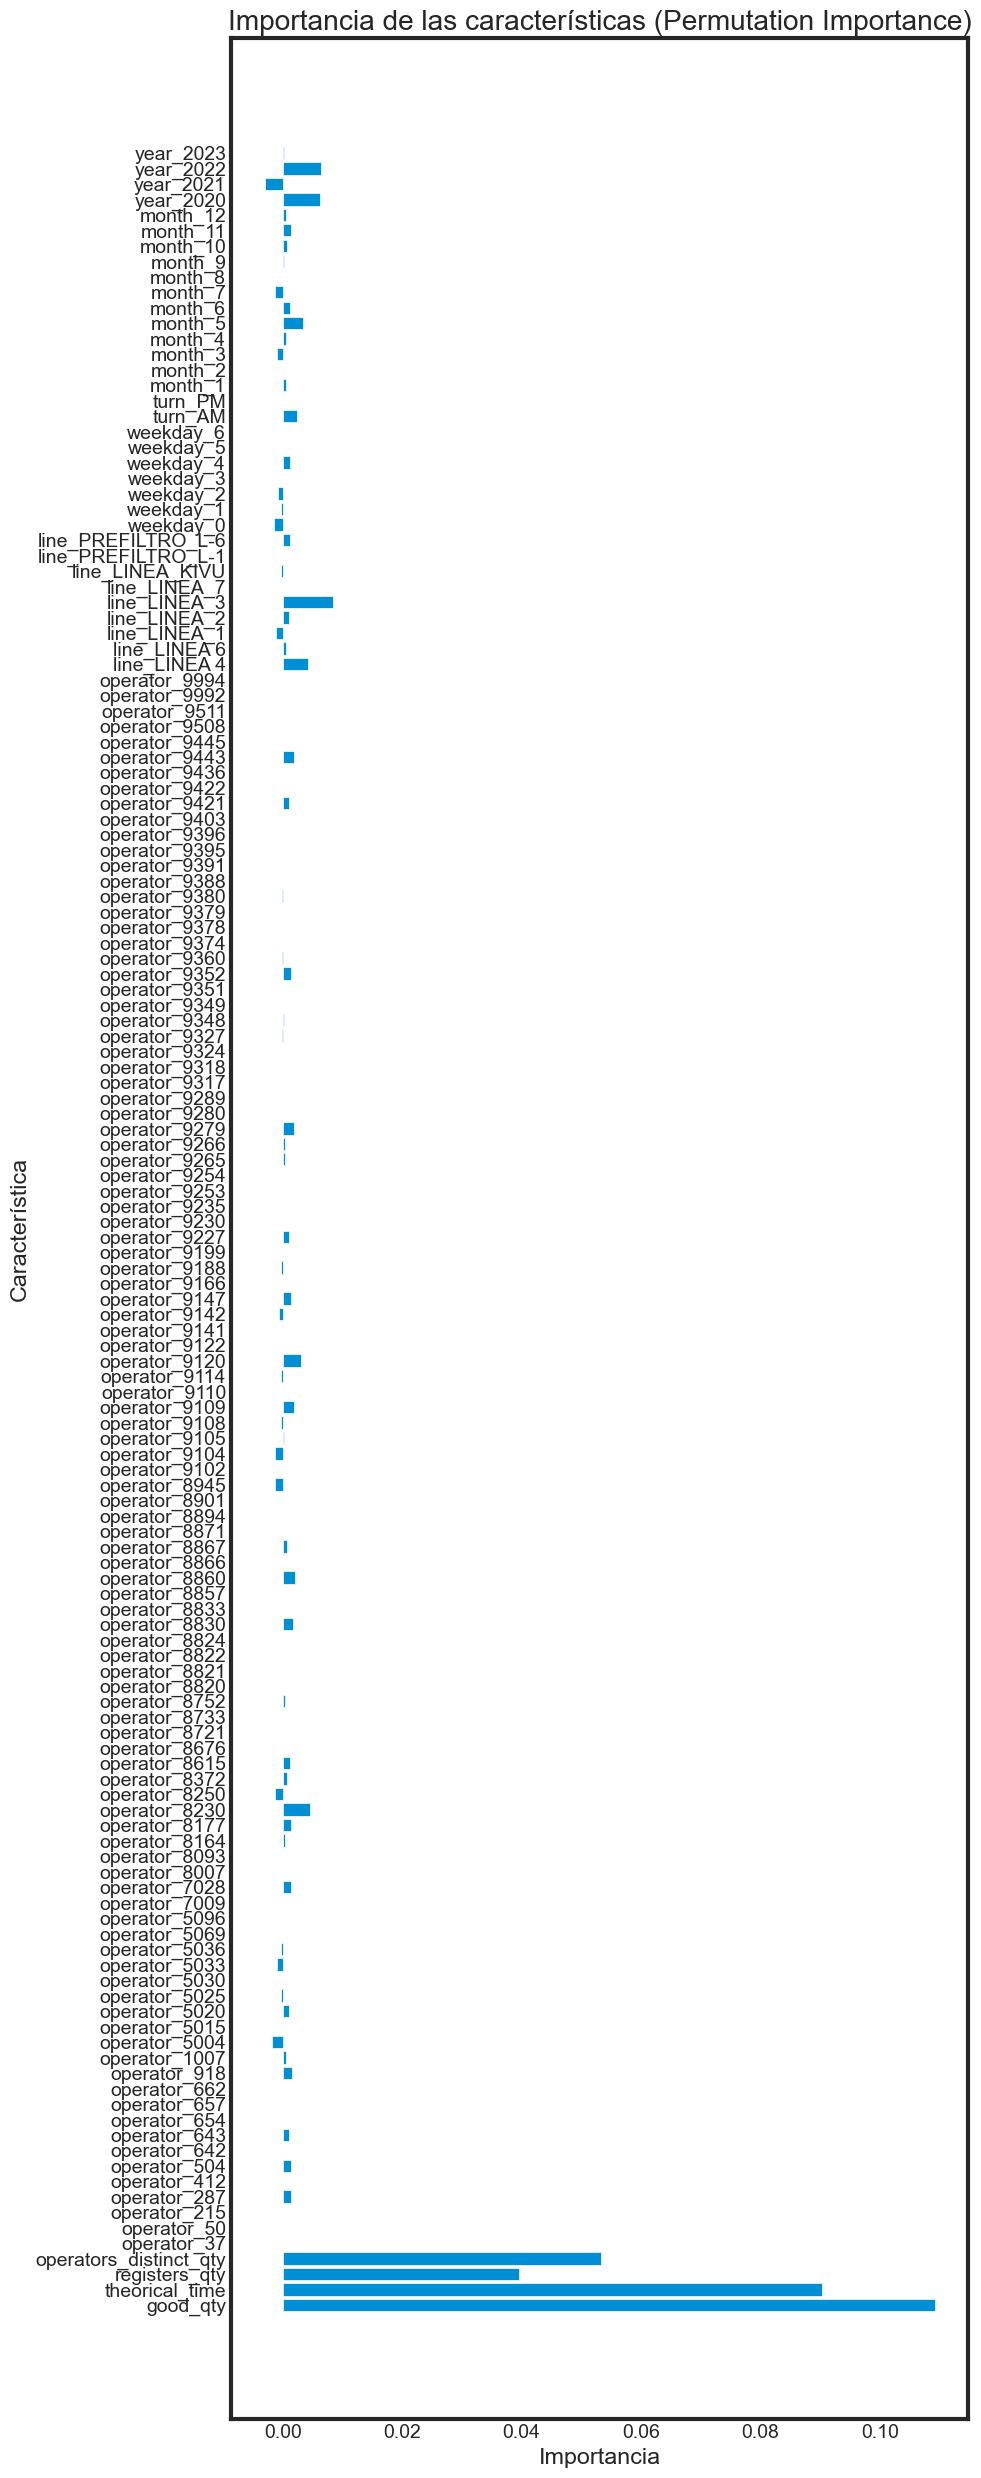

In [47]:
feature_names = data.feature
importance_scores = data.importance

# Crear un gráfico de barras de la importancia de las características
plt.figure(figsize=(10, 25))
plt.barh(feature_names, importance_scores)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características (Permutation Importance)')
plt.tight_layout()
plt.show()

Matriz de confusión

In [48]:
y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

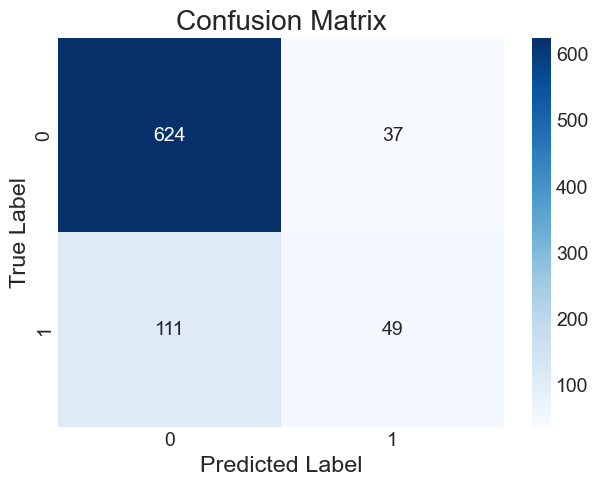

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Curva ROC

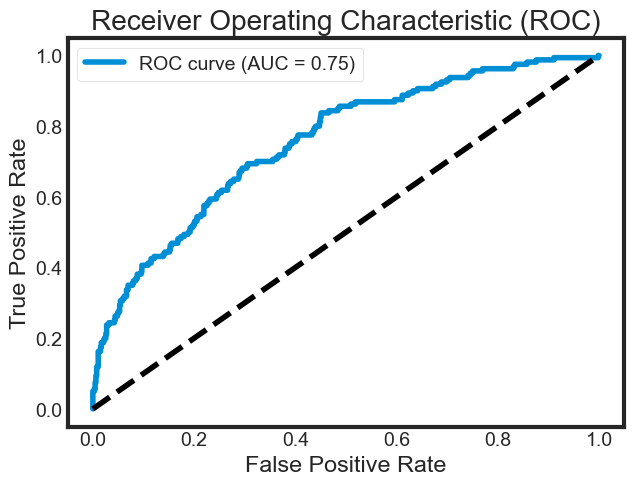

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular las probabilidades de las clases positivas
y_prob = model.predict_proba(X_test)[:, 1]

# Calcular la tasa de falsos positivos, la tasa de verdaderos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


Curva precisión Recal

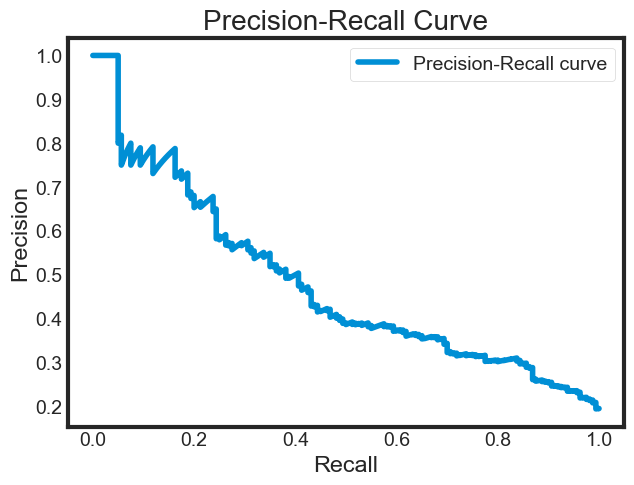

In [51]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular la precisión y la exhaustividad
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Graficar la curva de Precisión-Recall
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## XGBoost Regressor | Minutos-hombre 

In [52]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [53]:
df = df_merged.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [54]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [55]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,0.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,0.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,0.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,0.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,0.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,0.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [56]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [57]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

result = X_test.copy()
result['prediction'] = y_pred



In [58]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.96
Mean Absolute Error [MAE]: 117.53
Mean Squared Error [MSE]: 38433.82
Root Mean Squared Error [RMSE]: 196.05


Creamos la variable 'predicted_performance' para comoparar la performance real versus la calculada con la predicción

In [59]:
result['predicted_performance'] = (result.good_qty*result.theorical_time) / result.prediction
result.head()   

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,predicted_performance
2470,180.0,0.0,10.00,18,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1886.719116,0.954037
564,12.0,0.0,9.83,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,281.606079,0.418883
731,240.0,0.0,6.87,18,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1704.441772,0.967355
1073,90.0,0.0,21.54,37,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2304.930176,0.841067
2409,166.0,0.0,10.00,23,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2418.489502,0.686379


Join de results with the OFs dataframe

In [60]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,predicted_performance,order,bomb_type,line,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
2470,180.0,0.0,10.00,18,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1886.719116,0.954037,5280827,73680,LINEA_3,2021-12-01 10:15:13.750,2021-12-02 12:18:57.700,36950,36949.407,615.823450,1845.141683,184.514168,0.975535,10.263724,90% - 100%,2,AM,12,2021,0
564,12.0,0.0,9.83,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,281.606079,0.418883,5189979,20028,PREFILTRO_L-1,2020-05-15 07:49:18.700,2020-05-15 09:50:09.080,7251,7250.380,120.839667,188.458667,19.171787,0.625920,2.013994,60% - 70%,4,AM,5,2020,0
731,240.0,0.0,6.87,18,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1704.441772,0.967355,5197715,65560,LINEA_2,2020-06-03 13:21:10.360,2020-06-04 13:10:29.777,32322,32322.197,538.703283,1650.169417,240.199333,0.999170,8.978388,90% - 100%,2,AM,6,2020,0
1073,90.0,0.0,21.54,37,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2304.930176,0.841067,5209333,8005,LINEA 6,2020-08-05 10:16:43.327,2020-08-31 12:12:31.320,94411,94411.136,1573.518933,1949.779100,9

Precisión del modelo evaluando performance

In [61]:
r2 = r2_score(df_result_complete.performance, df_result_complete.predicted_performance)
mae = mean_absolute_error(df_result_complete.performance, df_result_complete.predicted_performance)
mse = mean_squared_error(df_result_complete.performance, df_result_complete.predicted_performance)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: -0.02
Mean Absolute Error [MAE]: 0.12
Mean Squared Error [MSE]: 0.03
Root Mean Squared Error [RMSE]: 0.19


Validación cruzada

In [62]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

Puntuaciones de rendimiento en cada división: [0.9584072  0.91934071 0.94447916 0.90961062 0.93533102]
Media de las puntuaciones de rendimiento: 0.933433742142847
Desviación estándar de las puntuaciones de rendimiento: 0.01740936118409234


In [63]:
comparison = pd.DataFrame({'TARGET': y_test, 'Predict': y_pred})
print(comparison)


           TARGET      Predict
2470  1845.141683  1886.719116
564    188.458667   281.606079
731   1650.169417  1704.441772
1073  1949.779100  2304.930176
2409  2212.864000  2418.489502
...           ...          ...
1018   449.432567   479.091583
2147  2190.309367  2238.707031
254   1179.964600  1252.599243
2770  1385.854250  1221.954712
2304   224.079383   384.872742

[821 rows x 2 columns]


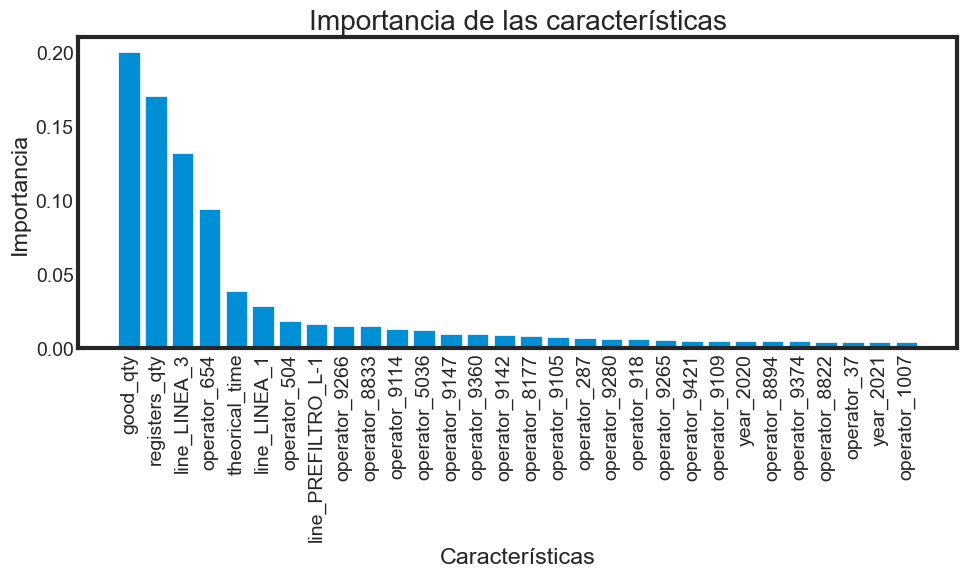

In [64]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:30]
sorted_feature_names = feature_names[indices][:30]

# Visualizar la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

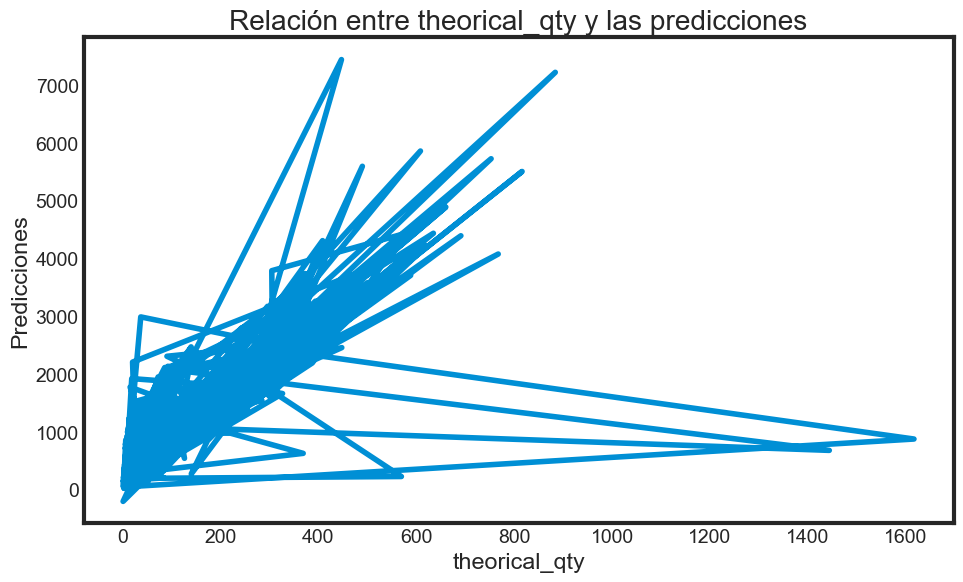

In [65]:
feature_name = 'theorical_qty'
# Graficar la relación entre la característica y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_result_complete[feature_name], y_pred)
plt.xlabel(feature_name)
plt.ylabel('Predicciones')
plt.title('Relación entre {} y las predicciones'.format(feature_name))
plt.show()

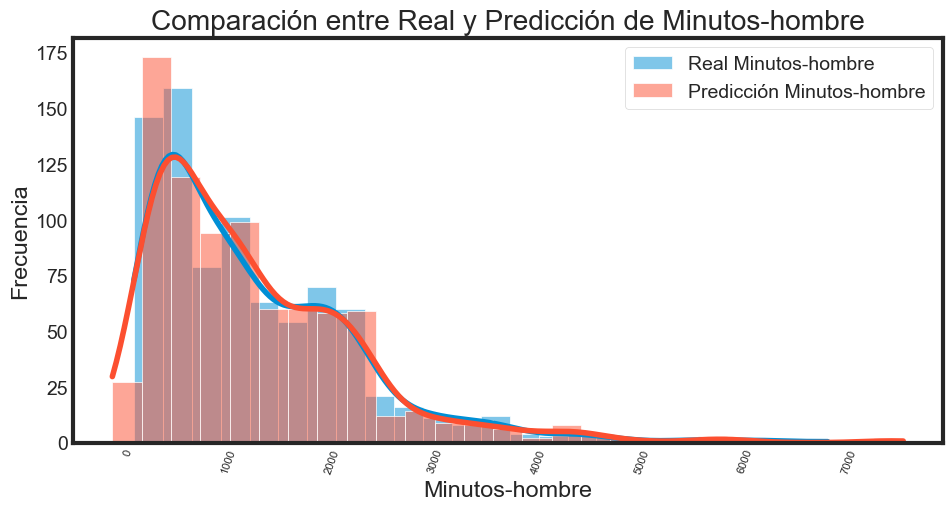

In [66]:
data = df_result_complete.sort_values(by='total_operators_minutes', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='total_operators_minutes', kde=True, label='Real Minutos-hombre')
sns.histplot(data=data, x='prediction', kde=True, label='Predicción Minutos-hombre')
plt.xlabel('Minutos-hombre')
plt.ylabel('Frecuencia')
plt.title(f'Comparación entre Real y Predicción de Minutos-hombre')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

## XGBoost Regressor | Performance

In [67]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [68]:
df = df_merged.copy()

TARGET = 'performance'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'total_operators_minutes',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [69]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [70]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,0.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,0.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,0.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,0.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,0.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,0.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [71]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [72]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

result = X_test.copy()
result['prediction'] = y_pred



In [73]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.49
Mean Absolute Error [MAE]: 0.09
Mean Squared Error [MSE]: 0.02
Root Mean Squared Error [RMSE]: 0.13


Join de results with the OFs dataframe

In [75]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,predicted_performance,order,bomb_type,line,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
2470,180.0,0.0,10.00,18,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.880279,2044.805823,5280827,73680,LINEA_3,2021-12-01 10:15:13.750,2021-12-02 12:18:57.700,36950,36949.407,615.823450,1845.141683,184.514168,0.975535,10.263724,90% - 100%,2,AM,12,2021,0
564,12.0,0.0,9.83,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.640543,184.156362,5189979,20028,PREFILTRO_L-1,2020-05-15 07:49:18.700,2020-05-15 09:50:09.080,7251,7250.380,120.839667,188.458667,19.171787,0.625920,2.013994,60% - 70%,4,AM,5,2020,0
731,240.0,0.0,6.87,18,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.973844,1693.084120,5197715,65560,LINEA_2,2020-06-03 13:21:10.360,2020-06-04 13:10:29.777,32322,32322.197,538.703283,1650.169417,240.199333,0.999170,8.978388,90% - 100%,2,AM,6,2020,0
1073,90.0,0.0,21.54,37,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.933835,2075.954874,5209333,8005,LINEA 6,2020-08-05 10:16:43.327,2020-08-31 12:12:31.320,94411,94411.136,1573.518933,1949.779100,9

Validación cruzada

In [77]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

Puntuaciones de rendimiento en cada división: [0.36841316 0.50320011 0.43621528 0.33316796 0.274992  ]
Media de las puntuaciones de rendimiento: 0.3831977017462782
Desviación estándar de las puntuaciones de rendimiento: 0.07955057898958588


In [78]:
comparison = pd.DataFrame({'TARGET': y_test, 'Predict': y_pred})
print(comparison)


        TARGET   Predict
2470  0.975535  0.880279
564   0.625920  0.640543
731   0.999170  0.973844
1073  0.994266  0.933835
2409  0.750159  0.722078
...        ...       ...
1018  1.076914  1.094030
2147  0.972465  0.936248
254   0.873247  0.868033
2770  0.699424  0.797124
2304  1.006786  0.772183

[821 rows x 2 columns]


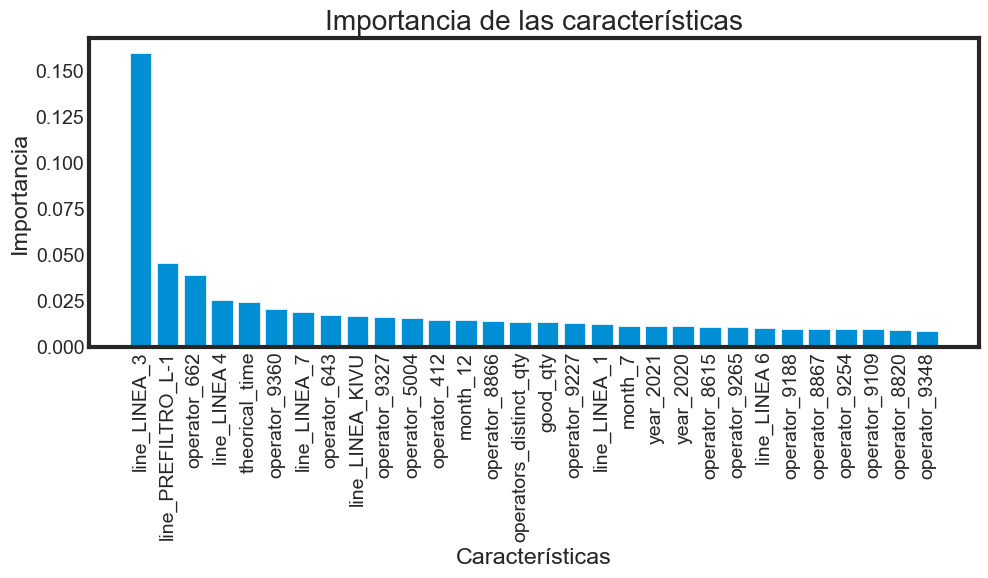

In [79]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:30]
sorted_feature_names = feature_names[indices][:30]

# Visualizar la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

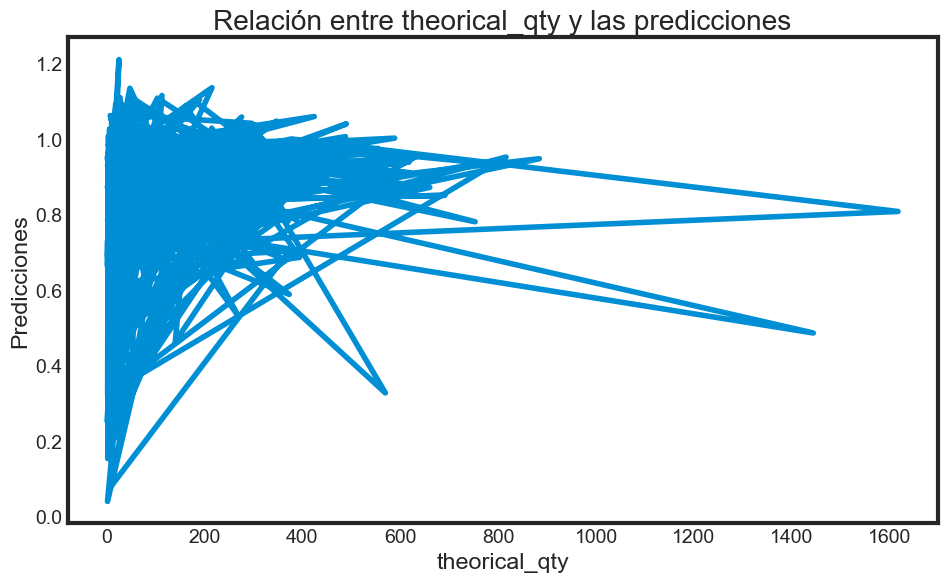

In [80]:
feature_name = 'theorical_qty'
# Graficar la relación entre la característica y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_result_complete[feature_name], y_pred)
plt.xlabel(feature_name)
plt.ylabel('Predicciones')
plt.title('Relación entre {} y las predicciones'.format(feature_name))
plt.show()

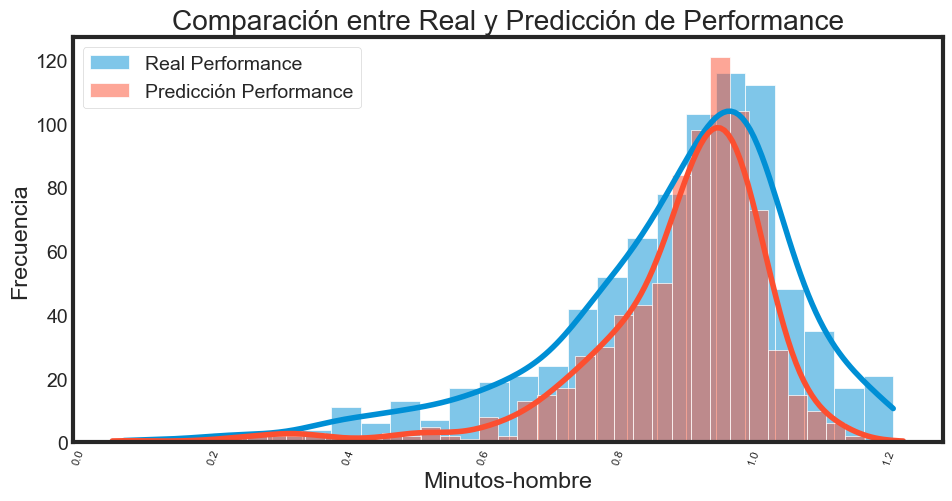

In [82]:
data = df_result_complete.sort_values(by='performance', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', kde=True, label='Real Performance')
sns.histplot(data=data, x='prediction', kde=True, label='Predicción Performance')
plt.xlabel('Minutos-hombre')
plt.ylabel('Frecuencia')
plt.title(f'Comparación entre Real y Predicción de Performance')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()